In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
rng = np.random.default_rng()

## chapter 2
### 1. 
use the rate given by equation 2.1 with $r_0$ = 50Hz and
$$
D(\tau) = -\cos(\frac{2\pi(\tau - 20 \text{ms} )}{140\text{ms}})\exp(-\frac{\tau}{60\text{ms}}) \text{Hz/ms}
$$

to predict the response of a neuron of the electrosensory lateral-line lobe to a stimulus
- above equation is an approximation for the linear kernel obtained from the STA in fig 1.9
- use approximate gaussian white noise stimulus constructed by choosing stimulus values at every 10ms ($\delta t$ = 10ms)
    - from gaussian distribution with zero mean and variance $\sigma^2_s / \delta t$ with $\sigma_s^2 = 10$
- compute firing rate over 10s  period
- from results, compare firing rate-stimulus correlation function $Q_{rs}(\tau)$ 
- using equation 2.6, compare $Q_{rs}(-\tau)/\sigma^2_s$ with kernel $D(\tau)$ given above

equation 2.1:
$r_{est}(t) = r_0 + \int_0^\infty d\tau D(\tau)s(t-\tau) $

equation 2.6:
$ D(\tau) = \frac{Q_{rs}(-\tau)}{\sigma^2_s} = \frac{\langle r \rangle C(\tau)}{\sigma^2_s} $

In [13]:
r0 = 50
dt = 10e-3
t = np.arange(0, 10, dt)
noise_std = np.sqrt(10/dt)
s = np.random.normal(0, noise_std, len(t))
kernel = -np.cos((2 * np.pi * (t - 20e-3)) / 140e-3) * np.exp(-t / 60e-3)

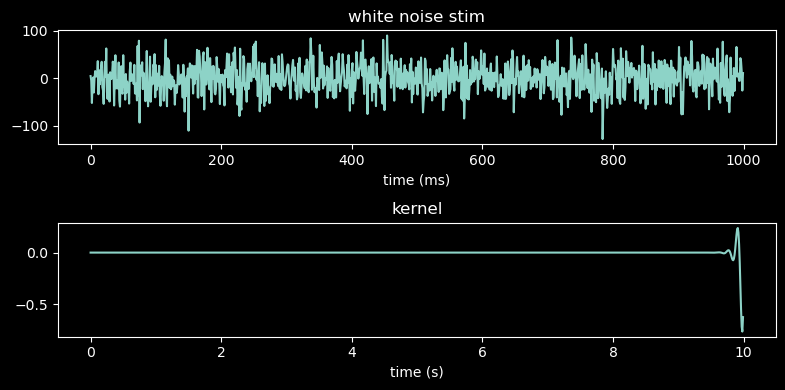

In [14]:
# check stimulus and kernel
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].plot(s)
ax[0].set_title('white noise stim')
ax[0].set_xlabel('time (ms)')
ax[1].plot(t[::-1], kernel)
ax[1].set_title('kernel')
ax[1].set_xlabel('time (s)')

plt.tight_layout()

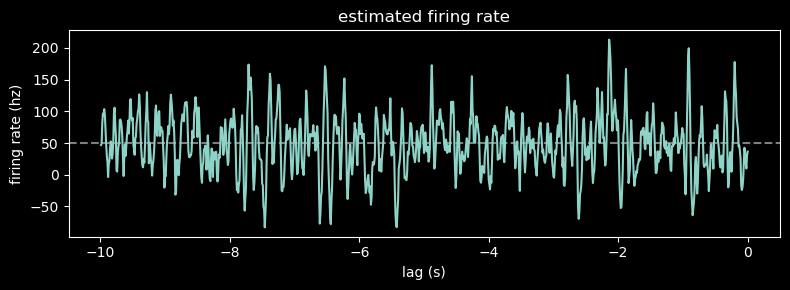

In [15]:
convolved = np.convolve(kernel, s, mode='full') + r0
lags = np.arange(-len(kernel)+1, len(kernel))*dt

fig, ax = plt.subplots(figsize=(8, 3))
ax.axhline(50, label='background firing rate', linestyle='--', alpha=0.5)
ax.plot(lags[:(int(np.ceil(len(lags)/2)))], convolved[:int(np.ceil(len(lags)/2))])
ax.set_title('estimated firing rate')
ax.set_xlabel('lag (s)')
ax.set_ylabel('firing rate (hz)')
plt.tight_layout()

In [16]:
# firing rate-stim autocorrelation 
r_est = convolved[:int(np.ceil(len(lags)/2))]
autocorr = np.correlate(s, r_est, mode='full') / (len(t))
autocorr = autocorr[:int(np.ceil(len(autocorr) / 2))] / noise_std**2

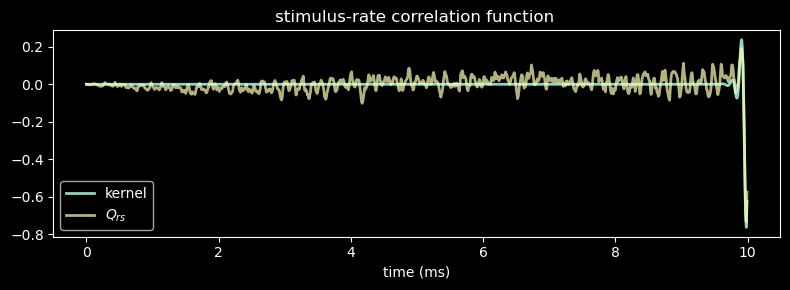

In [17]:
# good fit b/w kernel estimate and empirical autocorrelation! just noisier
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(t[::-1], kernel, label='kernel', linewidth=2)
ax.plot(t[::-1], autocorr[::-1], label='$Q_{rs}$', alpha=0.7, linewidth=2)
ax.set_title('stimulus-rate correlation function ')
ax.set_xlabel('time (ms)')
ax.legend()
plt.tight_layout()

### 2
use STA computed in c1p8 to construct a linear kernel and use it in equation 2.1 to provide a model of the response of the H1 neuron
- choose $r_0$ so that the average firing rate predicted by the model in response to the stimulus used for the data matches the actual average firing rate
- use a poisson generator with the computed rate to generate a synthetic spike train from this linear estimate of the firing rate in response to the stimulus `stim`
- plot examples of the actual and synthetic spike trains
    - how are they similar / different?
- plot autocorrelation function of actual and synthetic spike trains over range 0-100ms
    - why is there a dip at a lag of 2ms in the autocorrelation of the actual spike traim?
    - is there a dip for the synthetic train too?
- plot the ISI histogram for both spike trains
    - why is there a dip below 6ms in the actual spike train histogram?
- what are the coefficients of variation for the two spike trains and why might they differ?

In [18]:
# doing c1p8 STA again here
h1_data = pd.read_csv('C1P8.csv', header=None)
h1_data.rename(columns={0:'rho', 1:'stim'}, inplace=True)

dt8 = 2e-3
window_size = 300e-3

def get_sta(data, window_size, dt):
    window_steps = int(window_size/dt)
    sta_sum = np.zeros(window_steps)
    num_spikes = np.sum(data['rho'])
    # loop through spike train
    for i in range(window_steps, len(data['rho'])):
        # spike
        if data['rho'][i] == 1:
            # add preceding stimulus to spike-triggered sum
            sta_sum += np.asarray(data['stim'][i - window_steps:i])
    # get average of spike-triggered sum
    return sta_sum / num_spikes

sta8 = get_sta(h1_data, window_size, dt8)

In [81]:
stim_var = np.var(h1_data['stim'])
stim_mean = np.mean(h1_data['stim'])
spike_mean = np.mean(h1_data['rho']) / dt8 # Hz

equation 2.1:
$r_{est}(t) = r_0 + \int_0^\infty d\tau D(\tau)s(t-\tau) $

equation 2.6:
$ D(\tau) = \frac{Q_{rs}(-\tau)}{\sigma^2_s} = \frac{\langle r \rangle C(\tau)}{\sigma^2_s} $

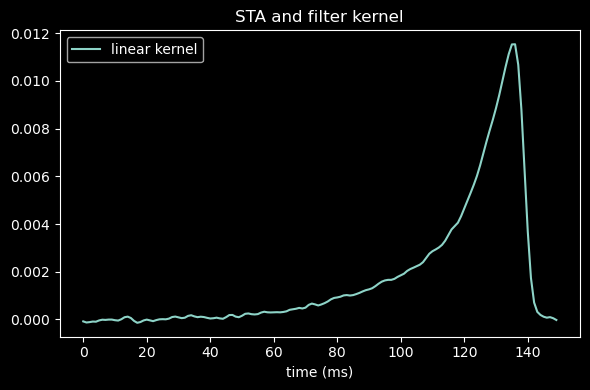

In [85]:
# pretend xticks are negative time
kernel8 = sta8 / stim_var
fig, ax = plt.subplots(figsize=(6, 4))
# ax.plot(sta8, label='h1 STA')
ax.plot(kernel8, label='linear kernel')
ax.set_title('STA and filter kernel')
ax.set_xlabel('time (ms)')
ax.legend()
plt.tight_layout()

In [123]:
r_est = np.convolve(h1_data['stim'], kernel8[::-1], mode='same')
np.mean(r_est) # want this to be ~44

-0.025550816171337754

In [124]:
#r_est += 45
syn_data = np.random.poisson(r_est * dt8)
syn_data[syn_data > 1] = 1

In [265]:
syn_times = np.where(syn_data)[0] * dt8
h1_times = np.where(h1_data['rho'])[0] * dt8

In [156]:
# mean firing rates for synthetic data and h1 data are similar
print(f'syn mean: {np.mean(r_est)}\n'
      f'real mean: {spike_mean}')

syn mean: 44.974449183828646
real mean: 44.6675


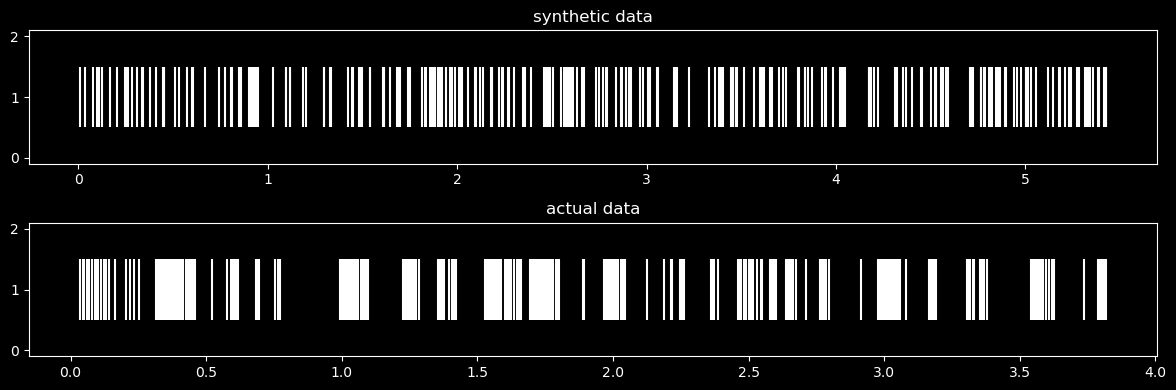

In [240]:
# spike trains are similar in that spike count rate (number of spikes / len(spike_train))
# synthetic data seems more continuous vs actual data is in groups of spikes
fig, ax = plt.subplots(2, 1, figsize=(12, 4))
ax[0].eventplot(syn_times[:250])
ax[0].set_title('synthetic data')
ax[1].eventplot(h1_times[:250])
ax[1].set_title('actual data')
plt.tight_layout()

In [192]:
actual_autocorr = np.correlate(h1_data['rho'], h1_data['rho'], mode='full')
syn_autocorr = np.correlate(syn_data, syn_data, mode='full')

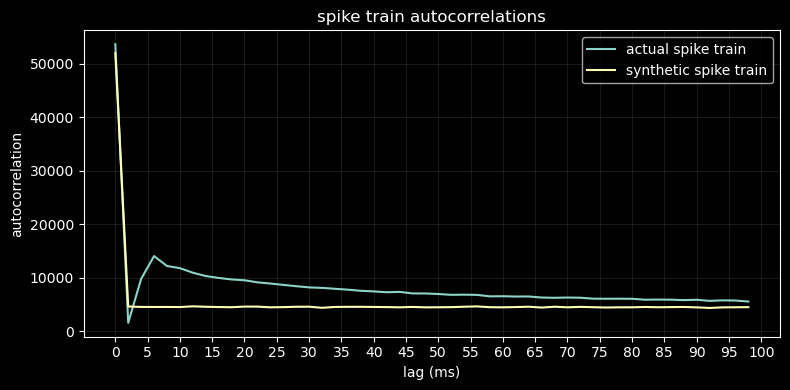

In [229]:
lag_steps = 50
midpoint = len(actual_autocorr)//2
range_start, range_end = midpoint, midpoint + lag_steps
lags = np.arange(0, lag_steps) * dt8 * 1000

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(lags, actual_autocorr[range_start:range_end], label='actual spike train')
ax.plot(lags, syn_autocorr[range_start:range_end], label='synthetic spike train')
ax.set_xlabel('lag (ms)')
ax.set_ylabel('autocorrelation')
ax.set_title('spike train autocorrelations')
ax.legend()

xticks = np.arange(0, lags[-1] + 5, 5)  # assuming lags[-1] is your maximum lag in ms
ax.set_xticks(xticks)
ax.grid(which='both', alpha=0.1)
plt.tight_layout()

dip at 2ms likely due to refractory period in actual H1 neurons, no dip at 2ms for the synthetic data that has no refractory period

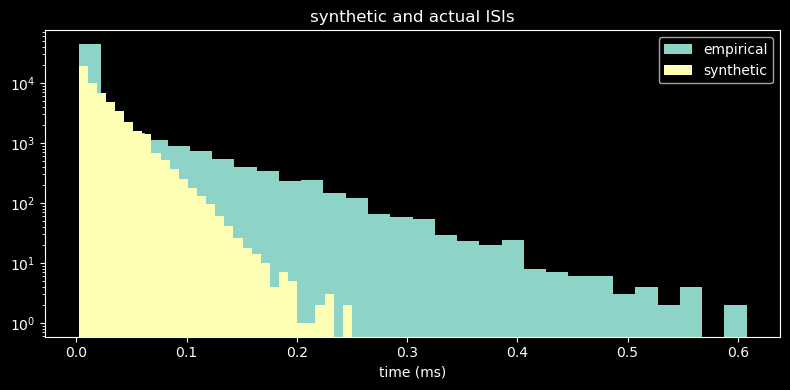

In [266]:
actual_isi = np.diff(h1_times)
syn_isi = np.diff(syn_times)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(actual_isi, bins=30, label='empirical')
ax.hist(syn_isi, bins=30, label='synthetic')
ax.set_yscale('log')
ax.set_title('synthetic and actual ISIs')
ax.legend()
ax.set_xlabel('time (ms)')

plt.tight_layout()

axis scaling above is likely off by an order in some direction, but dip in empirical ISIs below 0.6 is consistent with question about dip below 6ms
- refractoriness again? could be relative refractory period (not absolute like 2ms?)

In [267]:
# coefficients of variation
def get_cv(isi):
    return np.std(isi) / np.mean(isi)

actual_cv = get_cv(actual_isi)
syn_cv = get_cv(syn_isi)
print(f'actual cv: {actual_cv}\nsynthetic cv: {syn_cv}')

actual cv: 2.0085523370640965
synthetic cv: 0.9685497492751827


synthetic CV is around 1 while empirical CV is larger
- higher variability in ISIs, likely to non-poissonianism in neuron responses, biological factors etc
- synthetic is consistent with poisson process

### 3
file `c2p3.mat` contains responses from cat LGN cell to 2D visual images 
- `counts` is vector containin number of spikes in each 15.6ms bin
- `stim` contains 32767 16x16 images presented at the corresponding time
    - specifically, `stim(x, y, t)` is the stimulus present at coordinate `(x,y)` at time `t`
- calculate STA images for each of the 12 time steps before each spike and show them 
    - time bins can contain more than one spike, so STA must be computed by weighting each stimulus by number of spikes in the corresponding time bin
        - instead of weighting it by 1 or 0 depending on spike presence
    -  in averaged images, should see a central receptive field that reverses sign over time
    - produce image like 2.25C by summing images across one spatial dimension

In [279]:
# get data
import scipy.io
mat = scipy.io.loadmat('data/c2p3.mat')

In [284]:
counts = mat['counts'].flatten()
stim = mat['stim']

In [323]:
bin_size = 15.6
time_window = 100
time_steps = 12

In [327]:
def get_sta(stim, counts, time_steps):
    total_spikes = np.sum(counts)
    sta = np.zeros((16, 16, time_steps))

    for ii in range(time_steps, len(counts)):
        if counts[ii] > 0:
            for jj in range(time_steps):
                sta[:, :, jj] += stim[:, :, ii - jj - 1] * counts[ii]
    
    sta /= total_spikes
    return sta

def spatial_sta_sum(sta, axis=0):
    return np.sum(sta, axis=axis)


In [328]:
sta = get_sta(stim, counts, time_steps)
summed_sta = spatial_sta_sum(sta, 0)

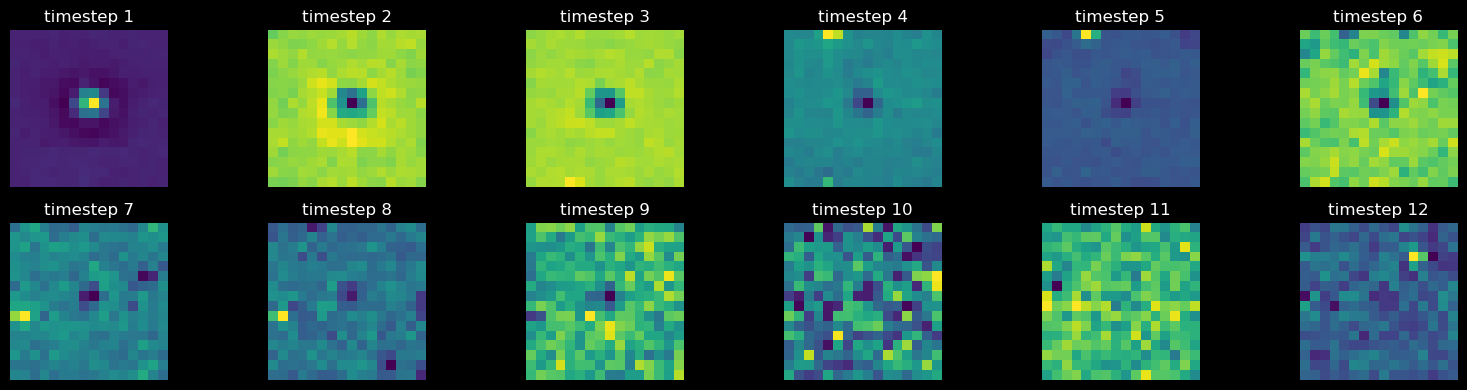

In [364]:
# plot at each timepoint
fig, axes = plt.subplots(2, 6, figsize=(16, 4))

for i in range(12):
    ax = axes[i//6][i%6]
    ax.imshow(sta[:, :, i])
    ax.set_title(f'timestep {i+1}')
    ax.axis('off')

plt.tight_layout()

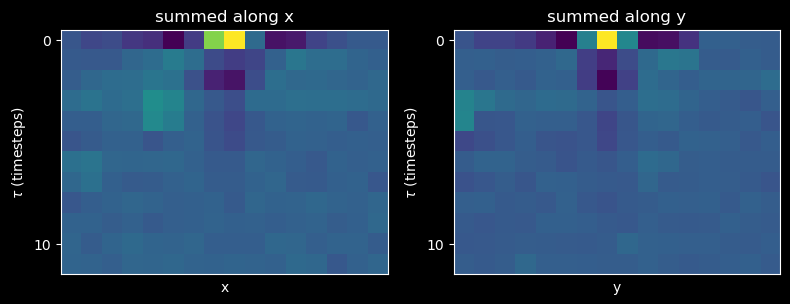

In [395]:
# sum across each spatial dimension
summed_x = spatial_sta_sum(sta, 0)
summed_y = spatial_sta_sum(sta, 1)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(summed_x.T)
ax[0].set_title('summed along x')
ax[0].set_xlabel('x')
ax[0].set_ylabel(r'$\tau$ (timesteps)')
ax[0].set_xticks([])
ax[0].set_yticks([0, 10])
ax[1].imshow(summed_y.T)
ax[1].set_title('summed along y')
ax[1].set_xlabel('y')
ax[1].set_ylabel(r'$\tau$ (timesteps)')
ax[1].set_xticks([])
ax[1].set_yticks([0, 10])
plt.tight_layout()


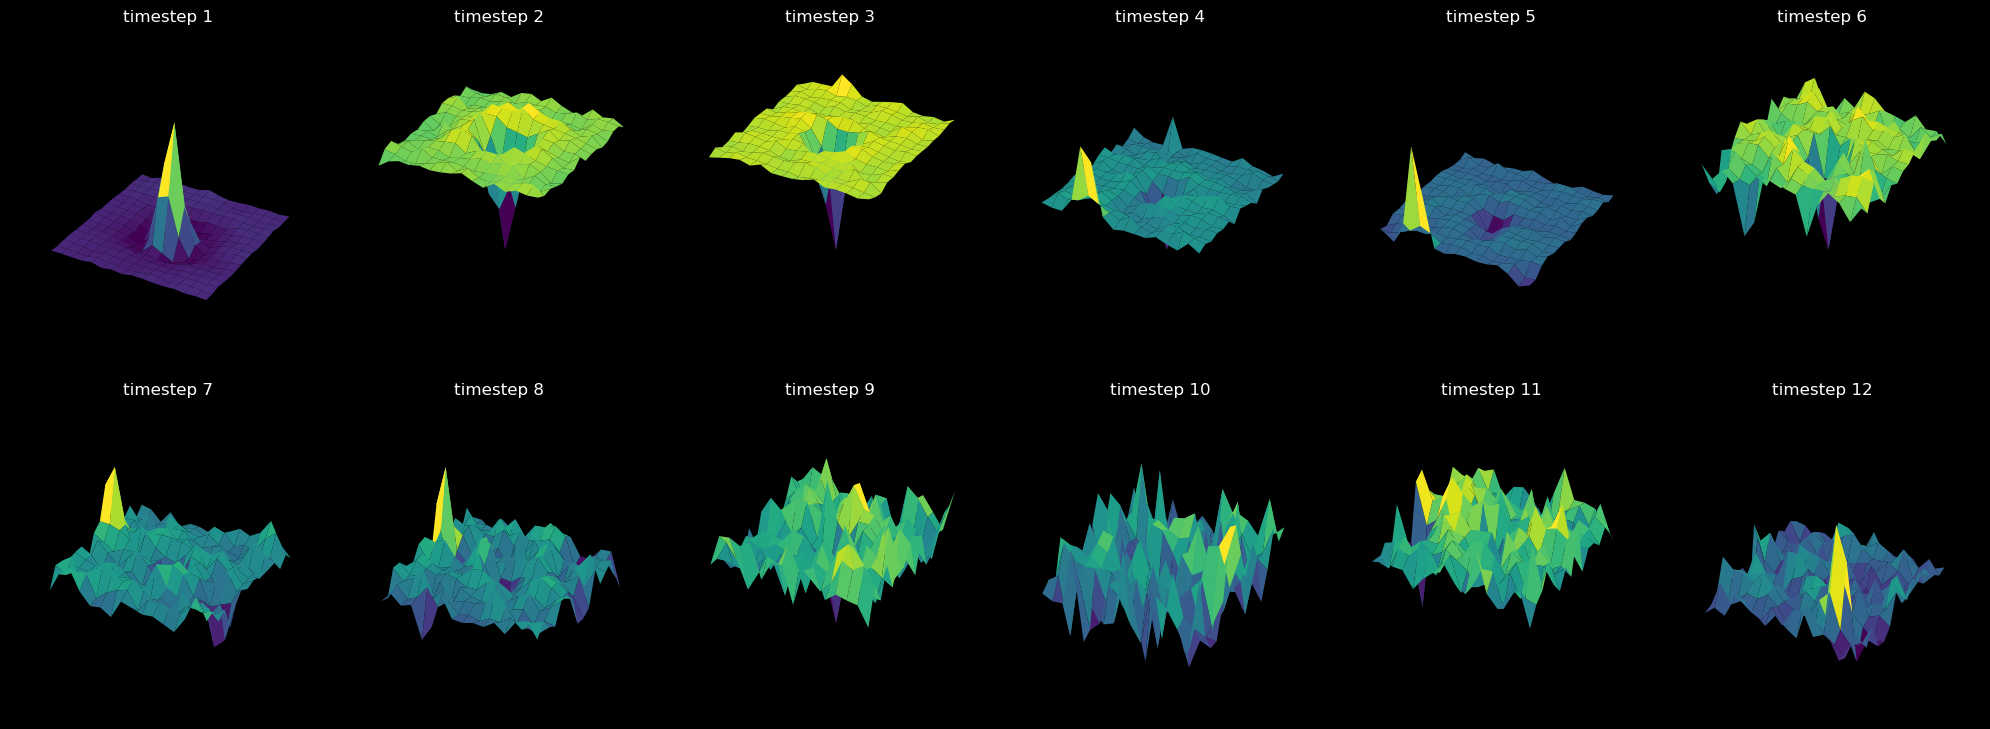

In [407]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_sta(sta, time_steps):
    x = np.arange(sta.shape[0])
    y = np.arange(sta.shape[1])
    X, Y = np.meshgrid(x, y)


    fig = plt.figure(figsize=(20, 8))

    for i in range(time_steps):
        ax = fig.add_subplot(2, 6, i//6 * 6 + i%6 + 1, projection='3d')
        ax.plot_surface(X, Y, sta[:, :, i], cmap='viridis')
        ax.set_title(f'timestep {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_3d_sta(sta, time_steps)

### 5
using:
$
\epsilon = \epsilon_0 (\exp(X / \lambda)-1)
$
and
$
a = -\frac{180\degree (\epsilon_0 + \epsilon)}{\lambda\epsilon\pi}
$,
map from cortical coordinates back to visual coordinates and determine what various patterns of activity across primary visual cortex would look like.

- consider various other patterns of activity and show the visual hallucinations they would generate

first, convert .m code into python, see what we are being asked to do

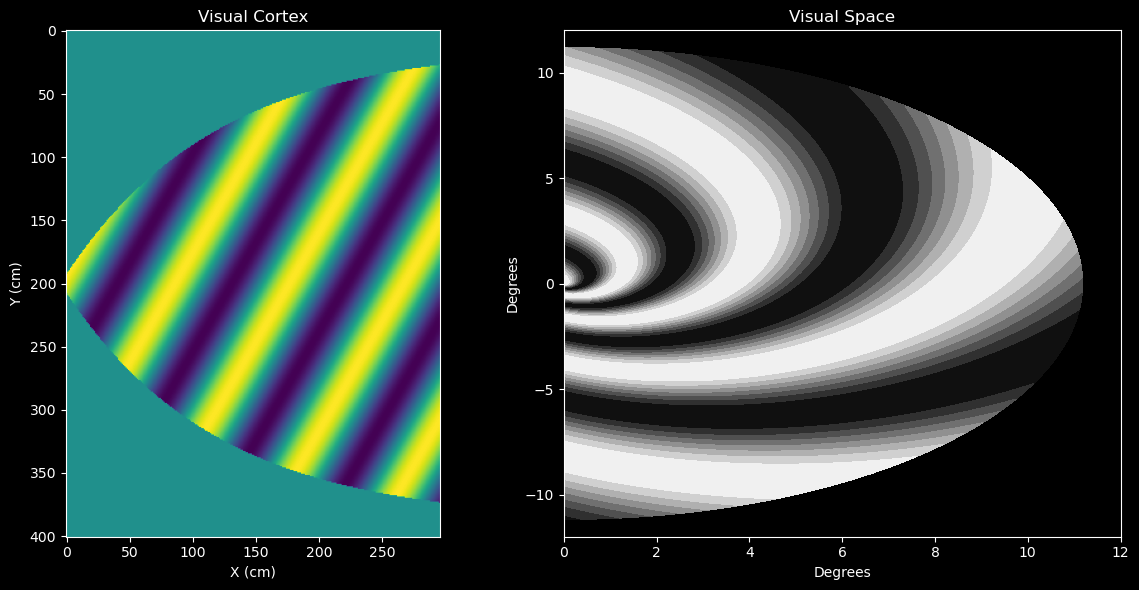

In [418]:
# code from c2p5.m converted to python

lam = 1.2
ep0 = 1.0
x, y = np.meshgrid(np.arange(0.05, 3.01, 0.01), np.arange(-2, 2.01, 0.01))

ep = ep0 * (np.exp(x / lam) - 1)
a = -(180 * (ep0 + ep) * y) / (lam * ep * np.pi)
a = np.where(np.abs(a) < 90, a, 90 * np.sign(a))

in_mask = np.abs(a) < 90

K = 8
Theta = np.pi / 6
Phi = 0
s = np.cos(K * x * np.cos(Theta) + K * y * np.sin(Theta) - Phi)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0.imshow(s * in_mask)
ax0.set_title('Visual Cortex')
ax0.set_xlabel('X (cm)')
ax0.set_ylabel('Y (cm)')

# Visual space pattern
ax1.contourf(ep * np.cos(a * 2 * np.pi / 360), ep * np.sin(a * 2 * np.pi / 360), s, cmap='gray')
ax1.set_xlim(0, 12)
ax1.set_ylim(-12, 12)
ax1.set_title('Visual Space')
ax1.set_xlabel('Degrees')
ax1.set_ylabel('Degrees')

plt.tight_layout()

now, functionalize so that we can run on different patterns easily

In [474]:
def get_eccentricity(x, lam, ep0):
    return ep0 * (np.exp(x/lam) - 1)

def get_azimuth(x, y, lam, ep0):
    epsilon = get_eccentricity(x, lam, ep0)
    azimuth = -(180 * (ep0 + epsilon) * y) / (lam * epsilon * np.pi)
    azimuth = np.where(np.abs(azimuth) < 90, azimuth, 90 * np.sign(azimuth))
    return azimuth

def cortical_to_visual(x, y, lam, ep0):
    epsilon = get_eccentricity(x, lam, ep0)
    azimuth = get_azimuth(x, y, lam, ep0)
    return epsilon, azimuth

def get_visual(ep, az, cortex_pattern, lam, ep0):
    x_viz = ep * np.cos(az * np.pi / 180)
    y_viz = ep * np.sin(az * np.pi / 180)
    
    from scipy.interpolate import griddata
    x_grid, y_grid = np.meshgrid(np.linspace(x_viz.min(), x_viz.max(), 100),
                                 np.linspace(y_viz.min(), y_viz.max(), 100))
    visual_pattern = griddata((x_viz.flatten(), y_viz.flatten()),
                               cortex_pattern.flatten(),
                               (x_grid, y_grid), method='cubic')
    return visual_pattern

recreate example using this code

In [475]:
# using same constants and grid from c2p5.m
lam = 1.2
ep0 = 1.0
x, y = np.meshgrid(np.arange(0.05, 3.01, 0.01), np.arange(-2, 2.01, 0.01))

k = 8
theta = np.pi / 6
phi = 0
cortex_pattern = np.cos(k * x * np.cos(theta) + k * y * np.sin(theta) - phi)
ep, az = cortical_to_visual(x, y, lam, ep0)
visual_pattern = get_visual(ep, az, cortex_pattern, lam, ep0)

seems about right

(0.0, 99.0, 0.0, 99.0)

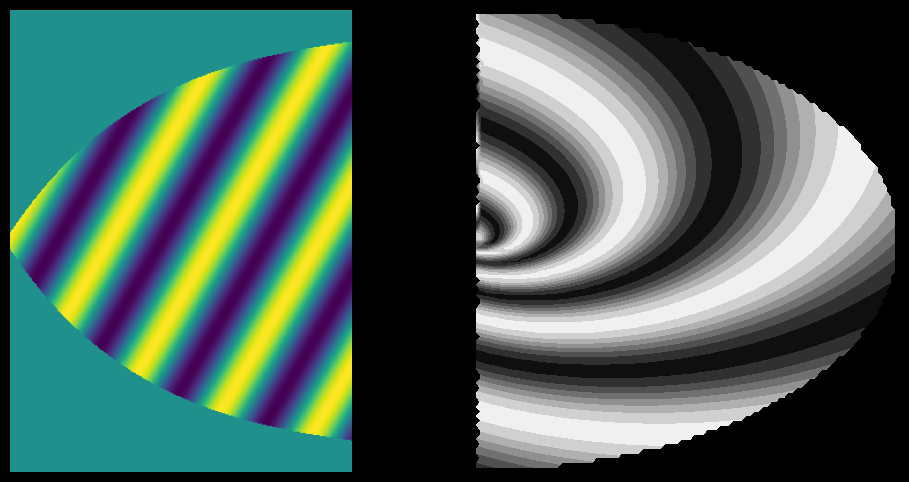

In [482]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0.imshow(cortex_pattern * in_mask)
ax1.contourf(visual_pattern,  cmap='gray')
ax0.axis('off')
ax1.axis('off')

try different patterns

In [505]:
patterns = {
    'radial': np.sin(np.sqrt(x**2 + y**2)**3),
    'checkerboard': np.sign(np.sin(x * 10) * np.sin(y * 10)),
    'gabor': np.exp(-(x**2 + y**2) / 0.5) * np.cos(10 * x),
    'spiral': np.sin(np.arctan2(y, x) * 10),
    'random': np.random.rand(*x.shape)
}

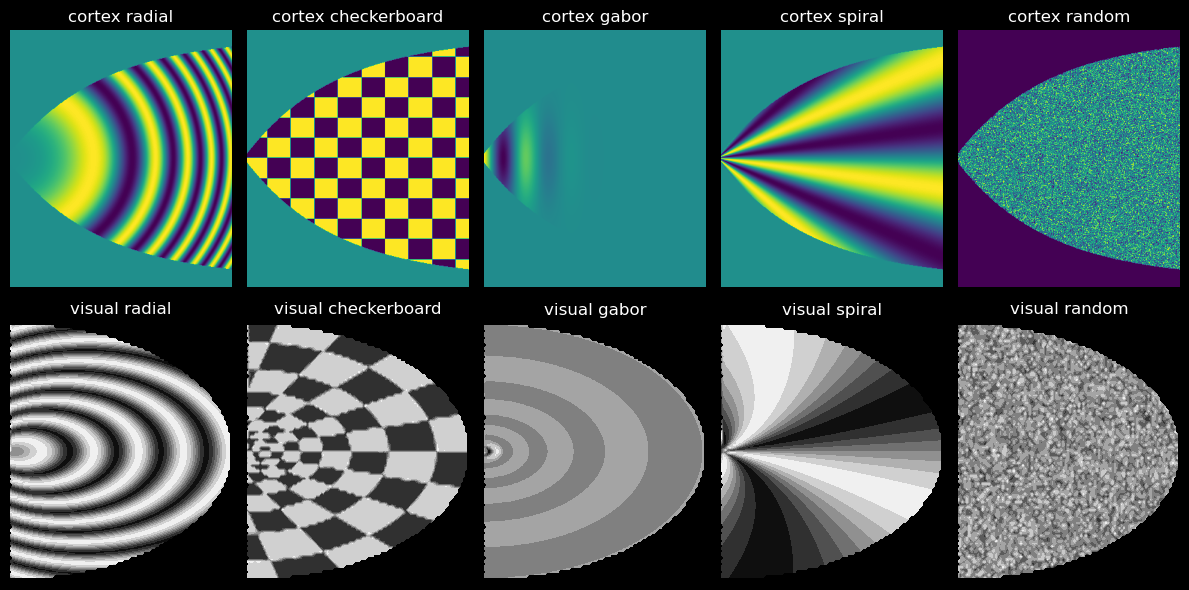

In [524]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, (pattern, equation) in enumerate(patterns.items()):
    cortex_pattern = equation
    visual_pattern = get_visual(ep, az, cortex_pattern, lam, ep0)
    cx = axes[0, i]
    cx.imshow(cortex_pattern * in_mask, aspect='auto')
    cx.set_title(f'cortex {pattern}')
    cx.axis('off')

    vz = axes[1, i]
    vz.contourf(visual_pattern, cmap='gray')
    vz.set_title(f'visual {pattern}')
    vz.axis('off')
    
plt.tight_layout()

### 6
perform integrals in eq 2.31 and 2.32 for the case $\sigma_x = \sigma_y = \sigma$ to obtain:

$
L_s = \frac{A}{2}\exp(-\frac{\sigma^2 (k^2 + K^2)}{2})(\cos(\phi - \Phi)\exp(\sigma^2kK\cos(\Theta))) + \cos(\phi + \Phi)\exp(-\sigma^2kK\cos(\Theta))
$


and

$
L_t(t) = \frac{\alpha^2 \left|\omega\right|\sqrt{\omega^2+4\alpha^2}}{(\omega^2 + \alpha^2)^4}\cos(\omega t - \delta)
$

with 

$ \delta = 8\arctan(\frac{\omega}{\alpha}) + \arctan(\frac{2\alpha}{\omega}) - \pi $

from these results, verify the selectivity curves in fig2.15 and 2.16
- plot $\delta$ as a function of $\omega$

In [536]:
def linear(A, sigma, k, K, phi, Phi, theta):
    term1 = np.cos(phi - Phi) * np.exp(sigma**2 * k * K * np.cos(theta))
    term2 = np.cos(phi + Phi) * np.exp(-sigma**2 * k * K * np.cos(theta))
    return (A/2) * np.exp(-(sigma**2 * (k**2 + K**2))/2) * (term1 + term2)

def delta(omega, alpha):
    return np.arctan(omega/alpha) + np.arctan(2*alpha / omega) - np.pi

In [537]:
# values from 2.15
theta = phi = Phi = 0
sigma = 1
k = 2
K = 1
A = 1

In [546]:
theta_vals = np.linspace(-np.pi, np.pi, 100)
kk_vals = np.linspace(0, 3, 100)
phi_vals = np.linspace(-np.pi, np.pi, 100)

ls_theta = [linear(A, sigma, k, k, phi, phi, theta) for theta in theta_vals]
ls_kk = [linear(A, sigma, k, k_ratio * k, phi, phi, 0) for k_ratio in kk_vals]
ls_phi = [linear(A, sigma, k, k, phi, Phi, 0) for Phi in phi_vals]

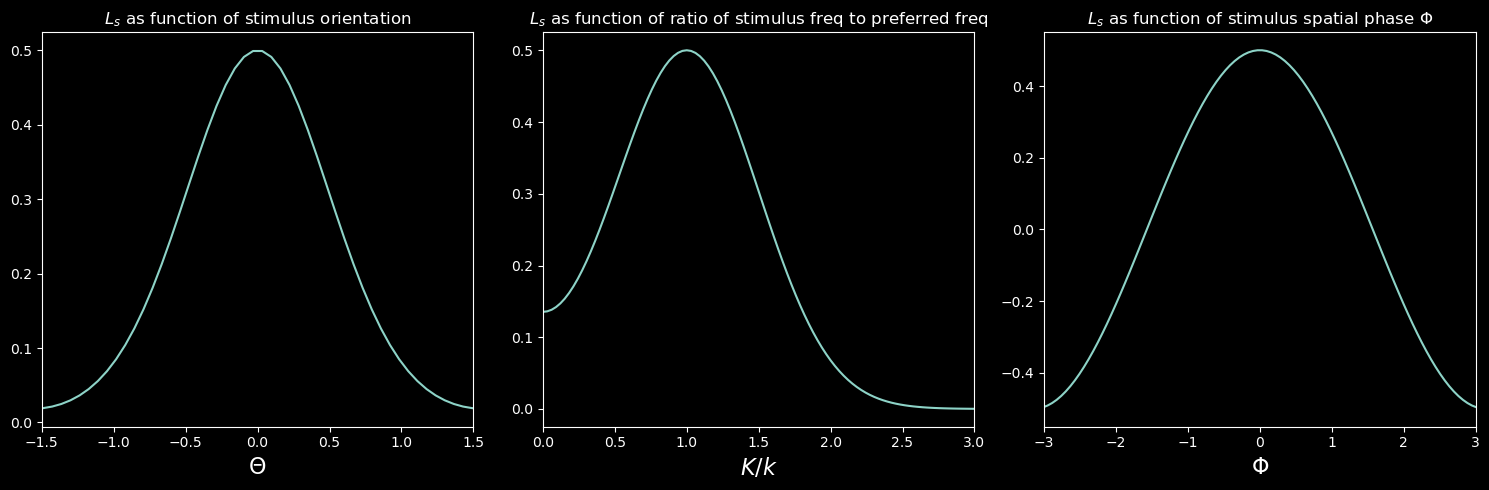

In [557]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# plot A
ax[0].plot(theta_vals, ls_theta)
ax[0].set_xlim(-1.5, 1.5)
ax[0].set_xlabel('$\Theta$', fontsize=16)
ax[0].set_title('$L_s$ as function of stimulus orientation')

# plot B
ax[1].plot(kk_vals, ls_kk)
ax[1].set_xlim(0, 3)
ax[1].set_xlabel('$K/k$', fontsize=16)
ax[1].set_title('$L_s$ as function of ratio of stimulus freq to preferred freq')

# plot C
ax[2].plot(phi_vals, ls_phi)
ax[2].set_xlim(-3, 3)
ax[2].set_xlabel('$\Phi$', fontsize=16)
ax[2].set_title('$L_s$ as function of stimulus spatial phase $\Phi$')

plt.tight_layout()

Text(0.5, 1.0, 'phase delay as function of temporal frequency')

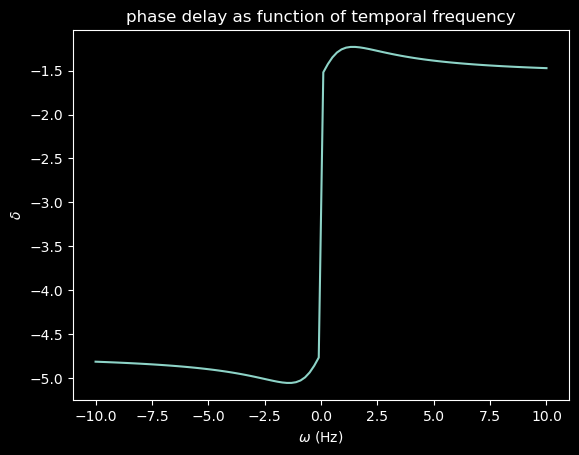

In [558]:
omega_vals = np.linspace(-10, 10, 100)
alpha = 1
delta_vals = [delta(omega, alpha) for omega in omega_vals]

plt.plot(omega_vals, delta_vals)
plt.xlabel('$\omega$ (Hz)')
plt.ylabel('$\delta$')
plt.title('phase delay as function of temporal frequency')

### 7
numerically compute the spatial part of the linear responseof a simple cell with a separable space-time receptive field to a sinusoidal grating, given by:
$
L_s = \int dxdy D_s(x,y)A\cos(Kx\cos(\Theta) + Ky\sin(\Theta) - \Phi)
$
- use a stimulus with orientation $\Theta = 0$
- for the spatial receptive field kernel, use: $D_s(x,y) = \frac{1}{2\pi\sigma_x\sigma_y}\exp(-\frac{x^2}{2\sigma_x^2} -\frac{y^2}{2\sigma_y^2})\cos(kx - \phi) $ with $\sigma_x = \sigma_y = 1\degree$ and $1/k = 0.5\degree$
- plot $L_s$ as a function of $K$ taking $\Phi = 0$ and $A = 50$
    - this determines the spatial phase selectivity of the cell. what is the preferred spatial phase?

In [580]:
sigma_x = sigma_y = np.deg2rad(1)
k = 2
A = 50
phi = 0

def Ds(x, y, phi=0):
    term1 = (1 / (2 * np.pi * sigma_x * sigma_y))
    term2 = np.exp(-((x**2 / 2*sigma_x**2)) - (y**2 / 2*sigma_y**2))
    term3 = np.cos(k*x - phi)
    return term1 * term2 * term3

def stim(x, K):
    return A * np.cos(K * x)

def Ls(x, y, K):
    return Ds(x, y) * stim(x, K)

In [581]:
from scipy.integrate import dblquad
# integrate over range 
k_vals = np.linspace(-50, 50, 100)
int_range = 5 * sigma_x
ls_vals = [dblquad(Ls, -int_range, int_range, lambda _: -int_range, lambda _: int_range, args=(K,))[0] for K in k_vals]

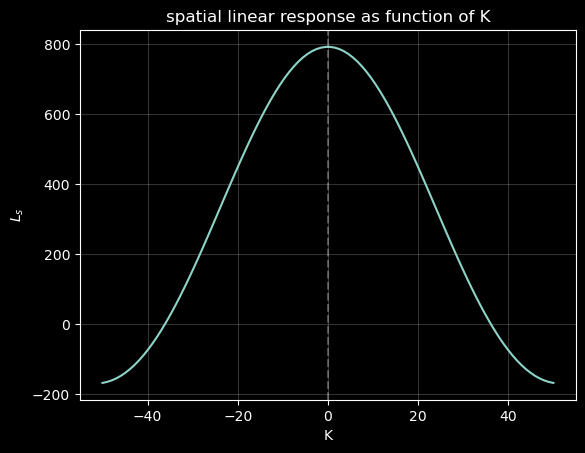

In [582]:
# preferred spatial phase is 0
plt.plot(k_vals, ls_vals)
plt.axvline(0, linestyle='--', alpha=0.3)
plt.xlabel('K')
plt.ylabel('$L_s$')
plt.title('spatial linear response as function of K')
plt.grid(True, alpha=0.2)

### 8
consider complex cell with the spatial part of its response given by $L_1^2 + L_2^2$ where $L_1$ and $L_2$ are linear responses determined by:
$
L_s = \int dxdy D_s(x,y)A\cos(Kx\cos(\Theta) + Ky\sin(\Theta) - \Phi)
$
with kernels by:
$D_s(x,y) = \frac{1}{2\pi\sigma_x\sigma_y}\exp(-\frac{x^2}{2\sigma_x^2} -\frac{y^2}{2\sigma_y^2})\cos(kx - \phi) $ with $\sigma_x = \sigma_y = 1\degree$ and $1/k = 0.5\degree$
    - with $\phi$ = 0 for $L_1$ and $\phi = -\pi / 2$ for $L_2$

- use stimulus oriented with $\Theta = 0$
- compute and plot $L_1^2 + L_2^2$ as a function of $K$ taking $\Phi = 0$ and A = 5
    - this determines the spatial frequency selectivity of the cell
- compute and plot $L_1^2 + L_2^2$ as a function of $\Phi$ taking $1/K = 0.5\degree$ and A = 5
    - this determines the spatial phase selectivity of the cell
- does the spatial cell selectivity match what you expect for a complex cell?

In [585]:
def complex_stim(x, y, K, theta, phi):
    return A * np.cos(K * x * np.cos(theta) + K * y * np.sin(theta) - phi)

def complex_ls(x, y, K, theta=0, phi=0):
    return Ds(x, y) * complex_stim(x, y, K, theta, phi)

def get_ls(K, phi):
    int_range = 5 * sigma_x
    ls, _ = dblquad(complex_ls, -int_range, int_range, lambda _: -int_range, lambda _: int_range, args=(K, phi))
    return ls

In [598]:
k_vals = np.linspace(-50, 50, 100)
A = 5
k_response_vals = []
l1_phi = 0
l2_phi = -np.pi / 2
for K in k_vals:
    l1 = get_ls(K, l1_phi)
    l2 = get_ls(K, l2_phi)
    response = l1**2 + l2**2
    k_response_vals.append(response)

phi_vals = np.linspace(-2*np.pi, 2*np.pi, 100)
k = 2

phi_response_vals = []
for p in phi_vals:
    l1 = get_ls(k, p)
    l2 = get_ls(k, p)
    response = l1**2 + l2**2
    phi_response_vals.append(response)

Text(0.5, 1.0, 'spatial phase selectivity')

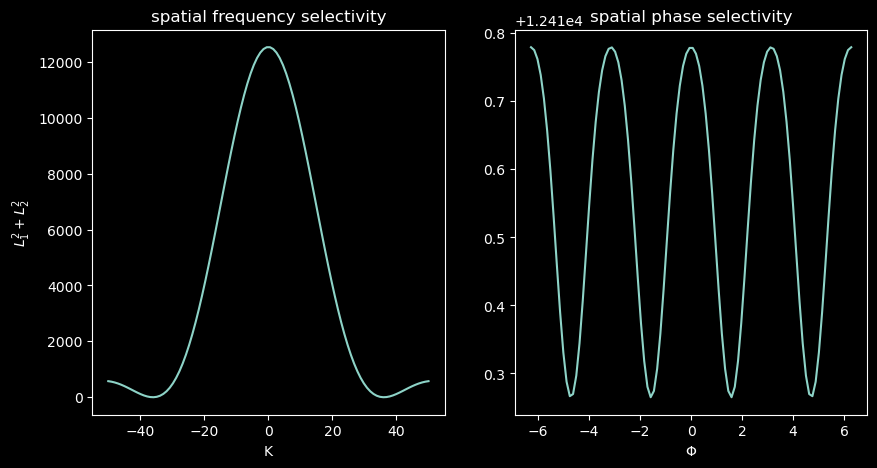

In [599]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(k_vals, k_response_vals)
ax[0].set_xlabel('K')
ax[0].set_ylabel('$L_1^2 + L_2^2$')
ax[0].set_title('spatial frequency selectivity')

ax[1].plot(phi_vals, phi_response_vals)
ax[1].set_xlabel('$\Phi$')
ax[1].set_title('spatial phase selectivity')

### 9
consider the linear temporal response for a simple or complex cell given by:
$
L_t(t) = \int_{0}^{\infty} d\tau D_t(\tau)\cos(\omega(t - \tau))
$
with a temporal kernel given by:
$
D_t(t) = \alpha\exp(-\alpha\tau)(\frac{(\alpha\tau)^5}{5!} - \frac{(\alpha\tau)^7}{7!})
$
with $1/\alpha = 15$ ms
- compute and plot $L_t(t)$ for $\omega = 6\pi / s$ 
- this determines the temporal response of the simple cell
- do not plot the negative part of $L_t(t)$ because the call cannot fire at a negative rate
- compute and plot $L_t^2(t) \space \text{for}\space \omega = 6\pi / s$ 
- this determines the temporal response of a complex cell
- what are the differences?

In [630]:
from scipy.integrate import quad
alpha = 1/15e-3
omega = 6 * np.pi

def Dt(tau):
    return alpha * np.exp(-alpha * tau) * (((alpha * tau)**5 / np.math.factorial(5)) - ((alpha * tau) ** 7 / np.math.factorial(7)))

def Lt(tau, t, omega=omega):
    return Dt(tau) * np.cos(omega * (t - tau))

def get_lt(t, omega=omega, alpha=alpha):
    tau_limit = 10/alpha
    result, _ = quad(Lt, 0, tau_limit, args=(t, omega))
    return result

In [640]:
# get L_t(t) 
t_vals = np.linspace(0, 1, 500)
lt_vals = np.array([get_lt(t, omega, alpha) for t in t_vals])
lt_rect = np.asarray([max(val, 0) for val in lt_vals])
lt2_vals = lt_vals**2

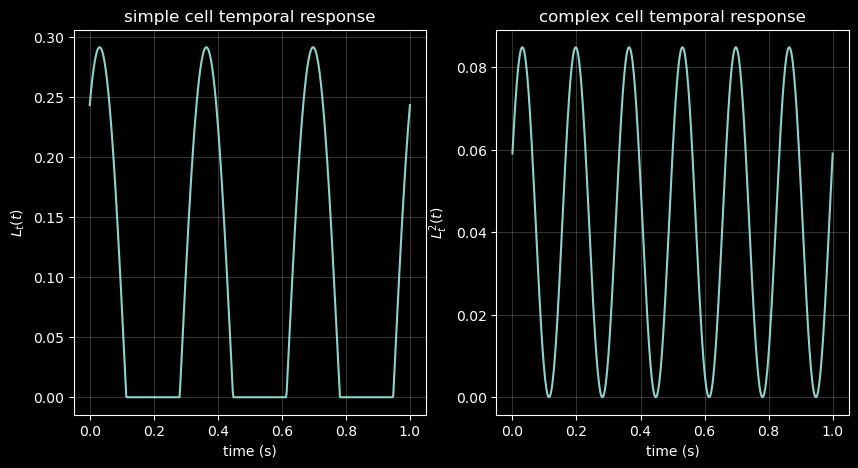

In [641]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(t_vals, lt_rect)
ax[0].set_title('simple cell temporal response')
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('$L_t(t)$')
ax[0].grid(True, alpha=0.2)

ax[1].plot(t_vals, lt2_vals)
ax[1].set_title('complex cell temporal response')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('$L_t^2(t)$')
ax[1].grid(True, alpha=0.2)

### 10
compute the response of a model simple cell with a separable space-time receptive field to a moving grating
$
s(x, y, t) = \cos(Kx - \omega t)
$

for $D_s$ use $D_s(x,y) = \frac{1}{2\pi\sigma_x\sigma_y}\exp(-\frac{x^2}{2\sigma_x^2} -\frac{y^2}{2\sigma_y^2})\cos(kx - \phi) $ with $\sigma_x = \sigma_y = 1\degree$, $\phi = 0$, and $1/k = 0.5\degree$

for $D_t$, use $D_t(t) = \alpha\exp(-\alpha\tau)(\frac{(\alpha\tau)^5}{5!} - \frac{(\alpha\tau)^7}{7!})$ with $1/\alpha = 15ms$ 

compute linear estimate of the response given by 

$L(t) = \int_0^{\infty} d\tau \int dxdy D(x, y, \tau)s(x, y, t - \tau)$

and assume that the actual response is proportional to a rectified version of this linear response estimate

- plot the response as a function of time for $1/K = 1/k = 0.5\degree$ and $\omega = 8\pi / s$ 
- plot the response amplitude as a function of $\omega$ for $1/K = 1/k = 0.5\degree$ and as a function of K for $\omega = 8\pi / s$ 

In [666]:
sigma_x = sigma_y = np.deg2rad(1)
k = K = np.deg2rad(2)
alpha = 1/15e-3
omega = 8 * np.pi

def Ds(x, y, k=k):
    return (1 / (2 * np.pi * sigma_x * sigma_y)) * np.exp(-(x**2 / (2 * sigma_x**2) + y**2 / (2 * sigma_y**2))) * np.cos(k * x)

def Dt(tau):
    return alpha * np.exp(-alpha * tau) * (np.power(alpha * tau, 5) / np.math.factorial(5) - np.power(alpha * tau, 7) / np.math.factorial(7))

def stim(x, y, t, omega, k=k):
    return np.cos(k * x - omega * t)

def compute_ls(t, omega, k=k):
    # upper limit for spatial integration
    x_upper = y_upper = 5 * sigma_x

    def temporal(tau, t, omega):
        spatial, _ = dblquad(lambda x, y: Ds(x, y, k) * Dt(tau) * stim(x, y, t-tau, omega, k),
                             -x_upper, x_upper, lambda _: -y_upper, lambda _: y_upper)
        return spatial

    L, _ = quad(temporal, 0, 5/alpha, args=(t, omega))
    return L

In [663]:
t_vals = np.linspace(0, 1, 500)
l_vals = [max(compute_ls(t, omega), 0) for t in t_vals]

In [667]:
omega_vals = np.linspace(-20*np.pi, 20*np.pi, 100)
omega_response = [max(compute_ls(0.5, omega), 0) for omega in omega_vals]

k_vals = np.linspace(-10*k, 10*k, 100)
k_response = [max(compute_ls(0.5, omega, K), 0) for K in k_vals]


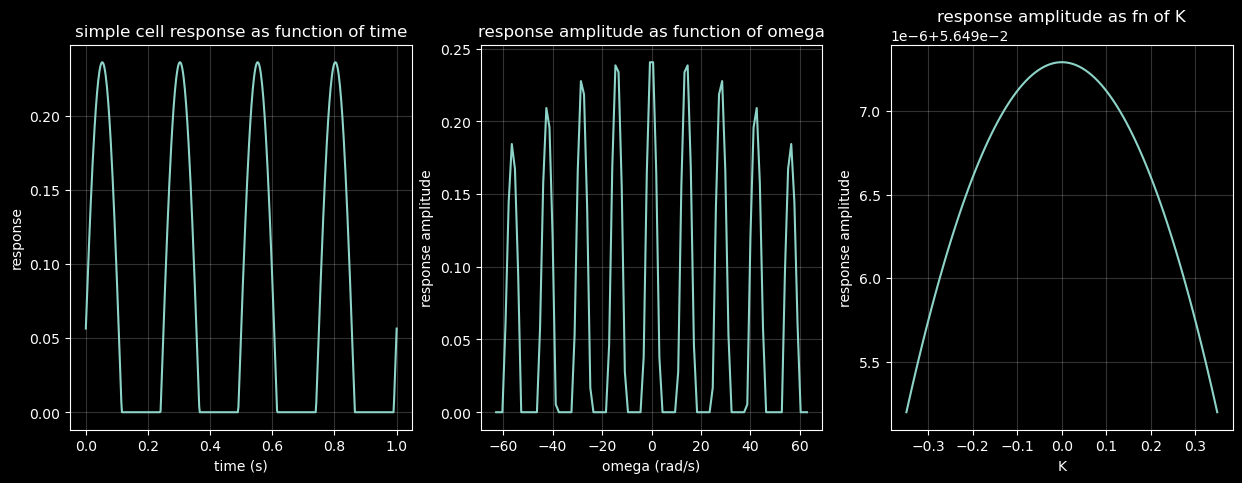

In [668]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(t_vals, l_vals)
ax[0].set_title('simple cell response as function of time')
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('response')
ax[0].grid(True, alpha=0.2)

ax[1].plot(omega_vals, omega_response)
ax[1].set_title('response amplitude as function of omega')
ax[1].set_xlabel('omega (rad/s)')
ax[1].set_ylabel('response amplitude')
ax[1].grid(True, alpha=0.2)

ax[2].plot(k_vals, k_response)
ax[2].set_title('response amplitude as fn of K')
ax[2].set_xlabel('K')
ax[2].set_ylabel('response amplitude')
ax[2].grid(True, alpha=0.2)